In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


emade_data = pd.read_csv('pareto2.csv')

sorted = emade_data.sort_values(by=['FullDataSet False Positives'])

for row in sorted.itertuples():
    print(str(row[16]) + ' ' + str(row[15]))


size = [row[16] for row in sorted.itertuples()]
fp = [row[14]/891 for row in sorted.itertuples()]
fn = [row[15]/891 for row in sorted.itertuples()]

#fp.insert(0, 0)
#fn.insert(0, 1)

#fp.append(1)
#fn.append(0)

print(len(fp))
print(len(fn))
print(len(size))

def print_pareto():
    plt.plot(fp, fn, color='r', drawstyle='steps-post')
    plt.xlabel("False Positives")
    plt.ylabel("False Negatives")
    plt.title("Pareto Front")
    plt.figure(figsize=(800, 800))
    plt.show()
    
def print_3d():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, si in enumerate(size):
        ax.scatter(fp[i], fn[i], zs=si, color = 'r')
    ax.set_xlabel('False Positives')
    ax.set_ylabel('False Negative')
    ax.set_zlabel('Size')

    
print_pareto()
f1 = np.array(fp)
f2 = np.array(fn)
    
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))





29 68.4
29 68.4
29 68.4
29 68.4
29 68.4
24 68.4
24 68.4
29 68.4
29 68.4
29 68.4
29 68.4
24 68.4
29 68.4
24 68.4
29 68.4
24 68.4
29 68.4
29 68.4
36 46.2
35 50.4
35 50.4
35 50.4
35 50.4
35 50.4
35 50.4
35 50.4
31 52.0
24 47.0
27 50.8
27 50.8
27 50.8
27 50.8
27 50.8
27 50.8
27 50.8
45 48.4
44 24.0
44 24.0
44 24.0
40 23.0
40 23.0
40 23.0
40 23.0
40 23.0
40 23.0
40 23.0
40 23.0
40 23.0
40 23.0
40 23.0
37 41.2
37 41.2
37 41.2
59 22.6
32 47.8
32 47.8
32 47.8
32 47.8
59 22.6
32 47.8
32 47.8
32 47.8
32 47.8
32 47.8
32 47.8
32 47.8
38 22.6
42 21.0
42 21.0
38 22.6
38 22.6
42 21.0
38 22.6
38 22.6
38 21.2
33 21.0
44 19.8
42 20.0
42 20.0
42 20.0
44 20.0
44 20.0
44 20.0
44 20.0
44 20.0
42 20.0
42 20.0
44 20.0
44 20.0
42 20.0
24 20.0
34 30.6
34 30.6
34 30.6
34 30.6
27 34.2
27 34.2
27 34.2
27 34.2
44 18.6
38 19.0
43 19.0
44 18.6
27 19.4
43 19.0
44 18.6
43 19.0
38 19.0
43 19.0
44 18.6
44 18.6
43 19.0
38 19.0
43 19.0
43 19.0
43 19.0
38 19.0
40 21.8
44 21.8
40 21.8
44 21.8
40 21.8
40 21.8
44 21.8
44 21.8


<Figure size 640x480 with 1 Axes>

<Figure size 80000x80000 with 0 Axes>

Area Under Curve: 0.0034526585218691464


In [2]:
import random
import operator
import itertools

import numpy as np
import matplotlib.pyplot as plt

from deap import base
from deap import creator
from deap import tools
from deap import gp

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#
#import networkx as nx
#import pygraphviz as pgv

"""----Data Processing----"""


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.columns[train_data.isna().any()].tolist()

train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

train_nan_map = {'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}
test_nan_map = {'Fare': test_data['Fare'].mean(), 'Embarked': test_data['Embarked'].mode()[0]}

train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

#Southampton Cherbourg Queenstown

columns_map = {'Sex': {'male': 0, 'female': 1}}

train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

titles = set()

for index, row in train_data.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	titles.add(title)

for index, row in test_data.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	titles.add(title)

titles.add("C")
titles.add("Q")
titles.add("S")
new_cols = dict()
for title in titles:
	new_cols[title] = [0 for x in range(0, train_data.shape[0])]


for index, row in train_data.iterrows():
	new_cols[row['Embarked']][index - 1] = 1
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	new_cols[title][index - 1] = 1

for column in new_cols.keys():
	train_data[column] = new_cols[column]

new_cols = dict()
for title in titles:
	new_cols[title] = [0 for x in range(0, test_data.shape[0])]

for index, row in test_data.iterrows():
	new_cols[row['Embarked']][index - 1 - train_data.shape[0]] = 1
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	new_cols[title][index - 1 - train_data.shape[0]] = 1

for column in new_cols.keys():
	test_data[column] = new_cols[column]

both = train_data.append(test_data)

title_age_sum = dict()
title_count = dict()

for title in titles:
	title_age_sum[title] = 0
	title_count[title] = 0

for index, row in both.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	if np.isnan(row['Age']):
		continue
	title_count[title] += 1
	title_age_sum[title] += row['Age']

for index, row in test_data.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	if not np.isnan(row['Age']):
		continue
	test_data.at[index, 'Age'] = title_age_sum[title] / title_count[title]


for index, row in train_data.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	if not np.isnan(row['Age']):
		continue
	train_data.at[index, 'Age'] = title_age_sum[title] / title_count[title]

del both['Name']
del both['Cabin']
del both['Ticket']
del both['Embarked']
del both['Survived']

mn = both.min()
mx = both.max()

del test_data['Name']
del test_data['Cabin']
del test_data['Ticket']
del test_data['Embarked']

y_train = train_data.loc[:, 'Survived']

del train_data['Name']
del train_data['Cabin']
del train_data['Ticket']
del train_data['Embarked']
del train_data['Survived']

test_data=(test_data-mn)/(mn+mx)
train_data=(train_data-mn)/(mn+mx)

X_train = train_data.loc[:]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)

truth = y_train.values


"""----Genetic Programming Setup----"""


pset = gp.PrimitiveSetTyped("MAIN", itertools.repeat(float, 27), bool, "IN")

"""Need to find best primitives/terminals"""

# boolean operators
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)
pset.addPrimitive(operator.xor, [bool, bool], bool)

# floating point operators
def safeDiv(left, right):
    try: return left / right
    except ZeroDivisionError: return 0
pset.addPrimitive(operator.add, [float,float], float)
pset.addPrimitive(operator.sub, [float,float], float)
pset.addPrimitive(operator.mul, [float,float], float)
pset.addPrimitive(safeDiv, [float,float], float)

# logic operators
def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

def relu(inp):
    if inp > 0:
        return inp
    return 0
pset.addPrimitive(relu, [float], float)

import math
def sigmoid(inp):
    return 1 / (1 + math.exp(-inp))

pset.addPrimitive(sigmoid, [float], float)
#pset.addPrimitive(math.sin, [float], float)

# terminals
for var in "abcdefghij":
    pset.addEphemeralConstant(var, lambda: random.random() * 100, float)
pset.addTerminal(0, bool)
pset.addTerminal(1, bool)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, pset=pset)

random.seed(25)


toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evaluate(individual,points,pset):
    func = gp.compile(expr=individual,pset=pset)
    predictions = [func(*points[x][:27]) for x in range(len(points))]
    tn, fp, fn, tp = confusion_matrix(truth, predictions).ravel()
    return fp/(fp+tp),fn/(fn+tn)
    
toolbox.register("evaluate", evaluate, points=X_train.values, pset=pset)

"""Need to find best selection, mating, mutation methods"""

NOBJ = 2
P = [2, 1]
SCALES = [1, 0.5]

# Create, combine and removed duplicates
ref_points = [tools.uniform_reference_points(NOBJ, p, s) for p, s in zip(P, SCALES)]
ref_points = np.concatenate(ref_points, axis=0)
_, uniques = np.unique(ref_points, axis=0, return_index=True)
ref_points = ref_points[uniques]

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mut_eph", gp.mutEphemeral, mode="one")

"""Need to test different max heights"""

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=27))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=27))
toolbox.decorate("expr_mut", gp.staticLimit(key=operator.attrgetter("height"), max_value=27))

def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal


"""----Genetic Algorithm----"""

popSize = 400
mateRate = .8
mutRate = .3

def evolvePop(popSize,mateRate,mutRate):
    
    pop = toolbox.population(n=popSize)
    hof = tools.ParetoFront()
    
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    hof.update(pop)
    
    for g in range(40):
        print("-- Generation %i --" % g)
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < mateRate:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
    
        for mutant in offspring:
            if random.random() < mutRate:
                toolbox.mutate(mutant)
                del mutant.fitness.values
            if random.random() < mutRate:
                toolbox.mut_eph(mutant)
                del mutant.fitness.values
                
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        pop[:] = offspring
        hof.update(pop)
    return hof,pop
hof, pop = evolvePop(popSize,mateRate,mutRate)


C:\Users\sanja\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\sanja\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\sanja\Anaconda3\lib\site-packages\ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sanja\Anaconda3\lib\site-packages\ipykernel_launcher.py:167: RuntimeWarning: divide by zero encountered in double_scalars


-- Generation 0 --
-- Generation 1 --


<string>:1: RuntimeWarning: invalid value encountered in double_scalars


-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --


0.0


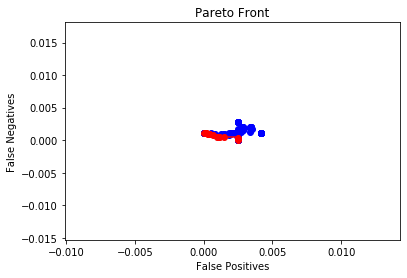

Area Under Curve: 1.5721951869574376e-06


In [3]:
def graphPareto(hof,pop):
    print(hof[0].fitness.values[0])
    fitness_1 = [ind.fitness.values[0]/len([x for x in truth if x]) for ind in hof] # % FP
    fitness_2 = [ind.fitness.values[1]/len([x for x in truth if not x]) for ind in hof] # % FN
    pop_1 = [ind.fitness.values[0]/len([x for x in truth if x]) for ind in pop]
    pop_2 = [ind.fitness.values[1]/len([x for x in truth if not x]) for ind in pop]
    
    plt.scatter(pop_1, pop_2, color='b')

    plt.xlabel("False Positives")
    plt.ylabel("False Negatives")
    plt.title("Pareto Front")
    plt.show()
    
    f1 = np.array(fitness_1)
    f2 = np.array(fitness_2)
    
    print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))
graphPareto(hof, pop)

[(0.15384615384615385, 0.15706806282722513, 'SVM poly'), (0.22115384615384615, 0.13612565445026178, 'SVM rbf'), (0.2403846153846154, 0.13089005235602094, 'SVM linear'), (0.27884615384615385, 0.12041884816753927, 'Gaussian Naive Bayes'), (0.2692307692307692, 0.11518324607329843, 'HistGradientBoostingClassifier')]


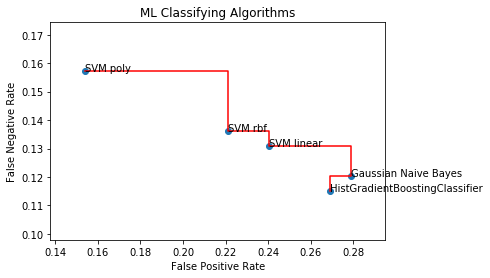

Area Under Curve: 0.019381796214256952
Best Accuracy: 0.8508474576271187


In [20]:
from sklearn import svm, tree, neighbors, neural_network
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn import ensemble

y_truth = y_test.values
model_performances = []
acc = []

svm_clf =  svm.SVC(kernel = "poly", tol = 1e-6, degree = 6, gamma = "scale")
svm_clf.fit(X_train.values, y_train.values)
y_pred = svm_clf.predict(X_test.values)
FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])
acc.append(svm_clf.score(X_test.values, y_test))

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "SVM poly"))

svm_clf =  svm.SVC(kernel = "rbf", tol = 1e-6, C = 2, gamma = "scale")
svm_clf.fit(X_train.values, y_train.values)
y_pred = svm_clf.predict(X_test.values)
FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])
acc.append(svm_clf.score(X_test.values, y_test))

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "SVM rbf"))

svm_clf =  svm.SVC(kernel = "linear", tol = 1e-6, C = 2, gamma = "auto")
svm_clf.fit(X_train.values, y_train.values)
y_pred = svm_clf.predict(X_test.values)
FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
acc.append(svm_clf.score(X_test.values, y_test))
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "SVM linear"))

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])
acc.append(clf.score(X_test.values, y_test))

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "Gaussian Naive Bayes"))

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

rf_clf = RandomForestClassifier(n_estimators=1750,max_depth=7,min_samples_split=6,min_samples_leaf=6,random_state=20,n_jobs=-1,) 
rf_clf.fit(X_train.values, y_train.values)
y_pred = rf_clf.predict(X_test.values)
FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])
acc.append(rf_clf.score(X_test.values, y_test))

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "Random Forest"))

hgb_cfl = ensemble.HistGradientBoostingClassifier(loss='auto', learning_rate=0.05)
hgb_cfl.fit(X_train.values, y_train.values)
y_pred = hgb_cfl.predict(X_test.values)

FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])
acc.append(hgb_cfl.score(X_test.values, y_test))

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "HistGradientBoostingClassifier"))

gb_clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.5, n_estimators=100, subsample=1.)
gb_clf.fit(X_train.values, y_train.values)
y_pred = gb_clf.predict(X_test.values)

FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])
acc.append(gb_clf.score(X_test.values, y_test))

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "GradientBoostingClassifier"))

mlp_clf = neural_network.MLPClassifier(hidden_layer_sizes = (90,), alpha = 1e-20, max_iter = 200, activation='tanh', solver='lbfgs', learning_rate='constant') 
#no tanh maybe relu >> identity >> 10ogistic, no SGD, maybe adam
#tanh + lbfgs ~.8 >> relu + adam
mlp_clf.fit(X_train.values, y_train.values)
y_pred = mlp_clf.predict(X_test.values)

FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])
acc.append(mlp_clf.score(X_test.values, y_test))

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "MLP"))

v_cfl = ensemble.VotingClassifier(estimators=[('mlp', mlp_clf), ('gb', gb_clf),('hgb', hgb_cfl)], voting='hard')
v_cfl.fit(X_train.values, y_train.values)
y_pred = v_cfl.predict(X_test.values)

FP = len([x for x in range(len(y_pred)) if y_truth[x] == False and y_pred[x] == True])
FN = len([x for x in range(len(y_pred)) if y_truth[x] == True and y_pred[x] == False])
acc.append(v_cfl.score(X_test.values, y_test))

model_performances.append((FP / len([x for x in y_truth if x]), FN / len([x for x in y_truth if not x]), "MLP with voting"))


lastFP, lastFN, name = model_performances[0]
pareto_optimal_models = [model_performances[0]]
allpoints = [[], [], []]
for FP, FN, model_name in model_performances:
	allpoints[0].append(FP)
	allpoints[1].append(FN)
	allpoints[2].append(model_name)
	if FP == lastFP:
		continue
	if FN < lastFN:
		pareto_optimal_models.append((FP, FN, model_name))
		lastFP = FP
		lastFN = FN
print(pareto_optimal_models)

points = [[], [], []]
for i in range(len(pareto_optimal_models)):
	points[0].append(pareto_optimal_models[i][0])
	points[1].append(pareto_optimal_models[i][1])
	points[2].append(pareto_optimal_models[i][2])


from matplotlib import pyplot
pyplot.title("ML Classifying Algorithms")
for i in range(len(points[0])):
    pyplot.annotate(points[2][i], (points[0][i], points[1][i]))
pyplot.scatter(points[0], points[1])
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("False Negative Rate")
pyplot.plot(points[0], points[1], color='r', drawstyle='steps-post')
pyplot.show()
f1 = np.array(points[0])
f2 = np.array(points[1])

print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))


print("Best Accuracy: %s" %(max(acc)))

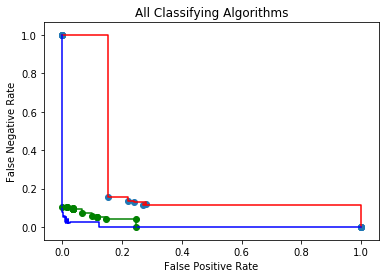

In [26]:
fp.insert(0, 0)
fn.insert(0, 1)

fp.append(1)
fn.append(0)

points[0].insert(0, 0)
points[1].insert(0, 1)

points[0].append(1)
points[1].append(0)

pyplot.title("All Classifying Algorithms")
pyplot.scatter(points[0], points[1])
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("False Negative Rate")
pyplot.plot(points[0], points[1], color='r', drawstyle='steps-post')
pyplot.plot(fp, fn, color='b', drawstyle='steps-post')

fitness_1 = [ind.fitness.values[0] * 100/len([x for x in truth if x]) for ind in hof] # % FP
fitness_2 = [ind.fitness.values[1] * 100/len([x for x in truth if not x]) for ind in hof] # % FN
pop_1 = [ind.fitness.values[0] * 100/len([x for x in truth if x]) for ind in pop]
pop_2 = [ind.fitness.values[1] * 100/len([x for x in truth if not x]) for ind in pop]
plt.scatter(fitness_1, fitness_2, color='g')
plt.plot(fitness_1, fitness_2, color='g', drawstyle='steps-post')




pyplot.show()